<a href="https://colab.research.google.com/github/huyminh1115/Trip-Advisor-Hotel-Project/blob/main/Code/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter, defaultdict

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import xgboost
import lightgbm as lgb
sns.set_style('whitegrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
df = pd.read_csv('./tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
grouped = df.groupby('Rating')['Rating'].count()
grouped

,Rating
Rating,
1,1421
2,1793
3,2184
4,6039
5,9054


<Axes: xlabel='Rating'>

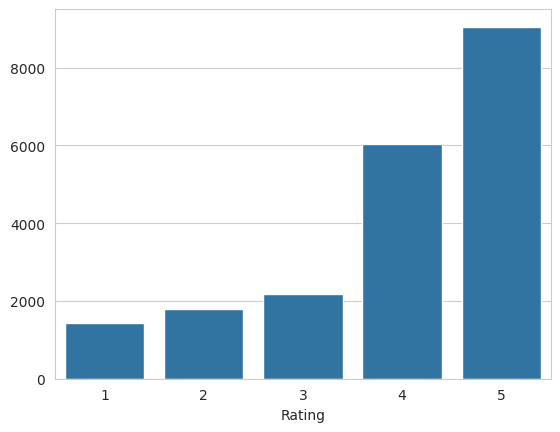

In [6]:
sns.barplot(x = grouped.index, y = grouped.values)

In [7]:
df['words'] = [x.split() for x in df['Review']]

df['word_count'] = [len(x) for x in df['words']]

df.head()

,Review,Rating,words,word_count
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191


In [8]:
grouped_rating = df.groupby('Rating')['word_count'].mean()
grouped_rating

,word_count
Rating,
1,112.365236
2,126.601227
3,114.705586
4,107.771651
5,93.963773


<Axes: xlabel='Rating'>

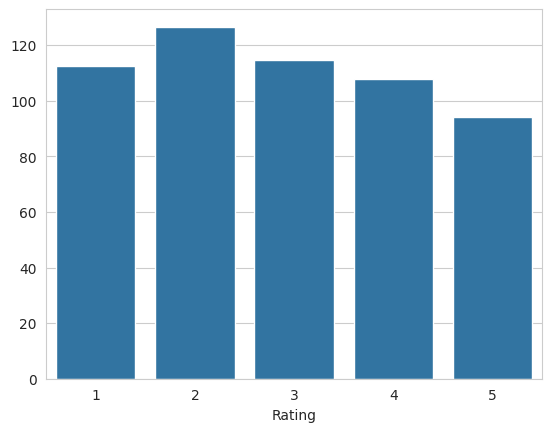

In [9]:
sns.barplot(x = grouped_rating.index, y = grouped_rating.values)

# Preprocessing

In [10]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [11]:
sw = stopwords.words('english')

In [35]:
def lemmatize_doc(text):
    # Process the text using the nlp pipeline
    doc = nlp(text)

    # Expand contractions and lemmatize the tokens
    lemmatized_text = []
    for token in doc:
            lemmatized_text.append(token.lemma_)

    # Join the lemmatized tokens into a string
    return ' '.join(lemmatized_text)

# Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    tag_map = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
    return tag_map.get(treebank_tag[0], wordnet.NOUN)


In [12]:
# :param doc: a document from the review corpus
# :return: a document string with words which have been
#         lemmatized,
#         parsed for stopwords,
#         made lowercase,
#         and stripped of punctuation and numbers.
def doc_preparer(doc, stop_words=sw):
    # Tokenize, lowercase, and filter stopwords in one step
    tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    words = [word.lower() for word in tokenizer.tokenize(doc) if word.lower() not in stop_words]

    # POS tagging and lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_doc = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tag(words)
    ]

    return ' '.join(lemmatized_doc)


In [26]:
# :param doc: a document from the review corpus
# :return: a document string with words which have been
#         lemmatized,
#         parsed for stopwords,
#         made lowercase,
#         and stripped of punctuation and numbers.
def doc_preparer_2(doc, stop_words=sw):
    doc = lemmatize_doc(doc)

    # Tokenize, lowercase, and filter stopwords in one step
    tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    # words = [word.lower() for word in tokenizer.tokenize(doc)]
    words = [word.lower() for word in tokenizer.tokenize(doc) if word.lower() not in stop_words or word.lower() == 'not']

    return ' '.join(words)


In [29]:
df['tokenized'] = df['Review'].apply(doc_preparer_2)

In [30]:
df.head()

,Review,Rating,words,word_count,tokenized
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room not experience hotel monaco seattle ...
3,"unique, great stay, wonderful time hotel monac...",5,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...


In [31]:
df['tokenized_words'] = [x.split() for x in df['tokenized']]


In [34]:
tokenized_words = df['tokenized_words'].to_list()
corpus = [word for i in tokenized_words for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),

    name='Most common Word',))

fig.update_layout(title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,

        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.update_layout(yaxis=dict(autorange="reversed"))

fig.show()

In [33]:
# Count how many times "n't" appears in the corpus
find_word = "not"
nt_count = corpus.count(find_word)

# Output the result
print(f"The word `{find_word}` appears {nt_count} times in the corpus.")

The word `not` appears 53228 times in the corpus.
